In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint

# 1. Adjustable parameters

First thing we need to do is physically define our problem. 
<br>
The easiest place to start is with what we already know about the situation. <br>
Take a look at the drawing below. This is a general depiction of the situation we will analyze in this script.
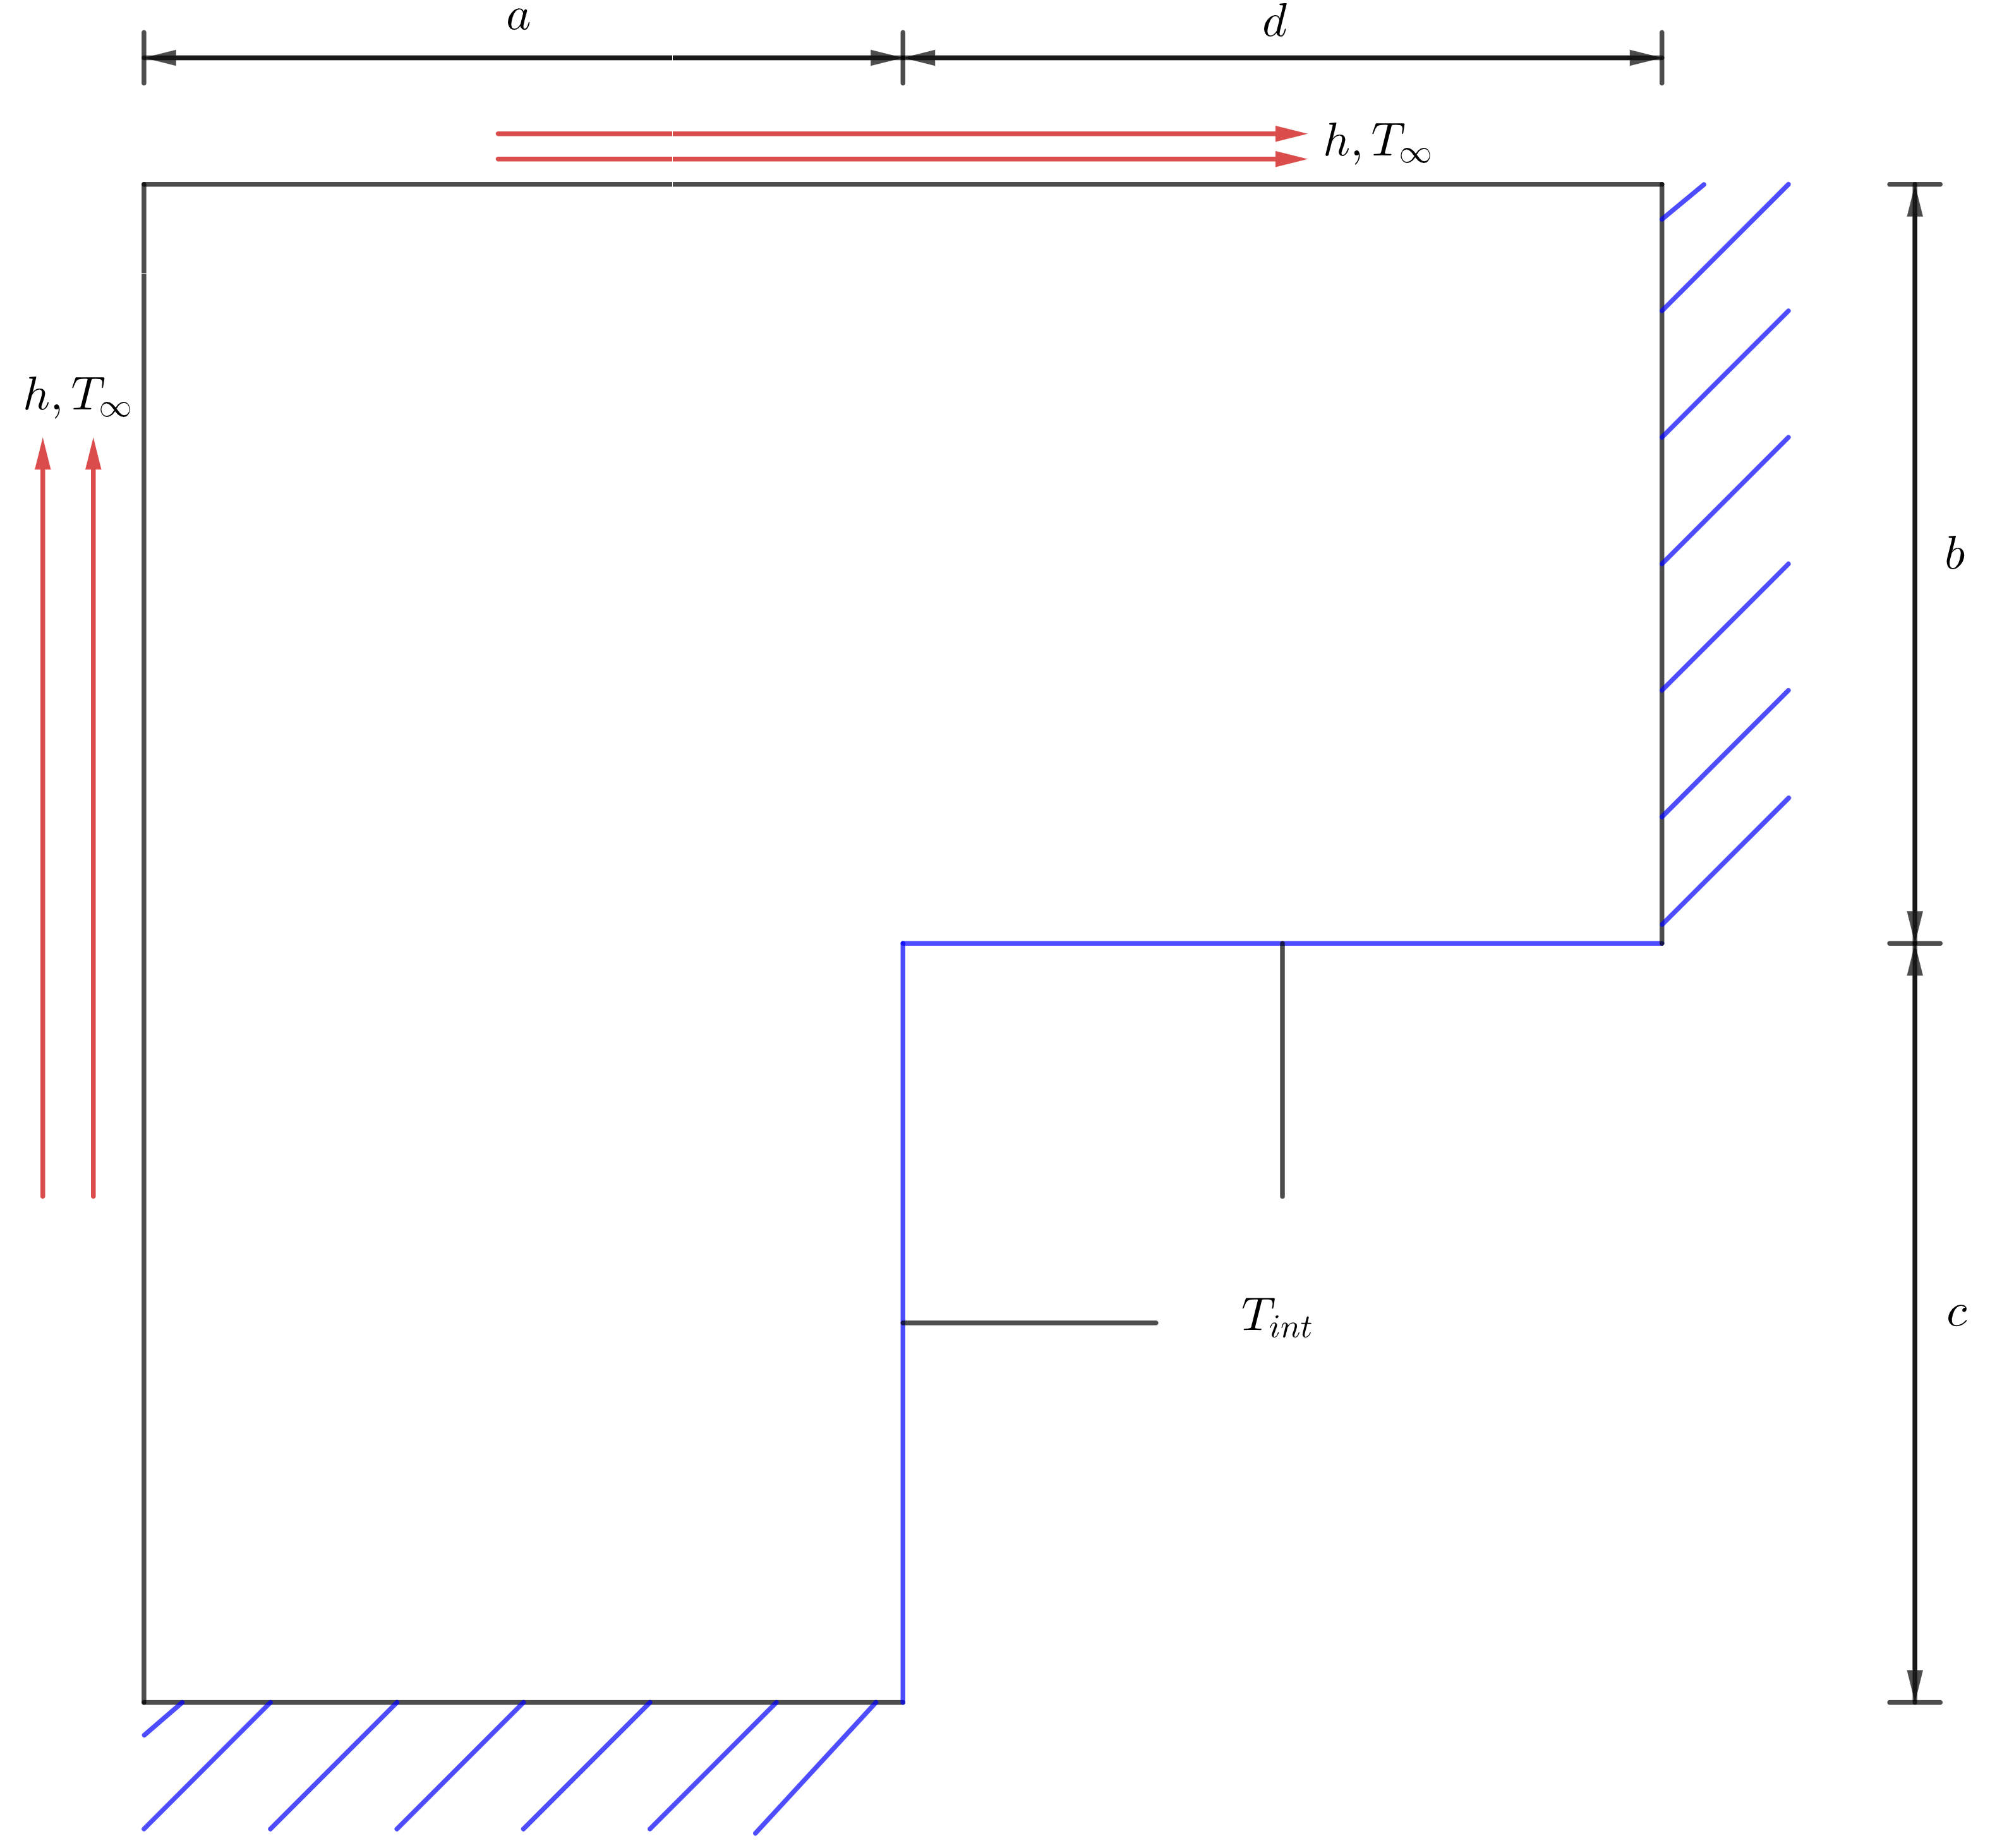

## Knowns that come from the problem situation

Our given situation tells us a temperature along the inner side of the corner and that the outside of the corner is exposed to convection. The material is assumed to be specified, so thermal conductivity is another known. Thus, right away, we already have things given to us or they can be referenced in a table or can be estimated with justifying reasons.

<br>
Below are sample values with justifying reasons in the comments. Feel free to change it to whatever your situation is. Don't forget to comment your reasons for picking those values.

In [2]:
h = 10 #convection coefficient for air (this was sourced from a table that table that was found via google search)
T_inf = 300 #a hot summer day (~80F)

k = 0.04 #a typical thermal conductivity value for expanded polystyrene (from google search), which is a common material for coolers 
         #NOTICE: We have a single value for k. What assupmtions are built into doing that?
    
T_int = 277 #from a general google search, this is a recommended maximum temperature for a cooler (~40F)

## Geometry
The corner has a fixed angle of 90°, so no need to make a variable to specify that. <br> 
To fully specify the corner geometry, we need to know where the 90° turn is and the overlength of both sides.


```a``` and ```b``` are the parameters that locate the 90° turn, and ```d``` and ```c``` add with ```a``` and ```b```, respectively to give the entire length of the side in question. Thus, these four parameters fully specify the corner geometry.
<br>
<br>
In this script we will tackle a simple corner geometry, because the goal of this script is to demonstrate numerical methods rather than posing and solving the most arbitrary corner geometry possible. So, all four lengths are the same, i.e. this is a symmetric corner. It is sufficient to only specify ```a```. Feel free to change it to what you want.

In [3]:
#half length of one side
a = .02  

#all other dimensions are the same, so that we have a symmetric corner
d = a
b = a
c = a

## Domain partitioning

With properties and geometry specified, the next thing we have to do is break up (partition) the geometry (the domain) into smaller pieces. For a rectangular corner, an easy way to partition is to cut it up into small rectangles. The height and width is something we get to decide. Below you will find a parameter you can adjust: ```I```.


```I``` is the parameter that sets the number of partitions in the x direction, specifically from the top left edge of the corner to ```a```. This parameter can be any value greater than or equal to zero. 

<br>
You can adjust the parameter how you want; just keep in mind that going too high will create a problem that requires too much computer memory to solve.

In [4]:
I = 10 #number of nodes desired between the top left corner and a (I can be any integer greater than or equal to zero)

We have specified how we want to partition one segment, and that is all we need because each one is the same length as ```a```. What we can then do is partition all the other segments in the same way too. ```J``` tells us how many nodes are in between ```a``` and ```a+d```. 
<br>
<br>
Finally, we need the height and width of the small rectangles (which are now squares, why?). We will call these small squares nodes. Each node has a width $\Delta x$, and because it is a square, the height $\Delta y$ is equal to $\Delta x$.

In [5]:
dx = a/(I+1) #width of each node
J = (d/dx) - 1 #number of equally spaced nodes between a and a+d

dy = dx 

print("dx:")
pprint(dx)

dx:
0.0018181818181818182


Finally, we want to know how many nodes we created in either direction.

<br>
We will call the total number of nodes in x as $m$. <br>
Because of symmetry, the total number of nodes in y, $n$, is the same as $m$.

In [6]:
m = int(I+J+3) #total number of nodes in x
print("m:")
pprint(m)

n = m
print("n:")
pprint(n)

m:
23
n:
23


That was pretty abstract. Let's get some visuals to help us understand it all. <br>
Below are drawings of partitioned domains for some values of $I$ <br>

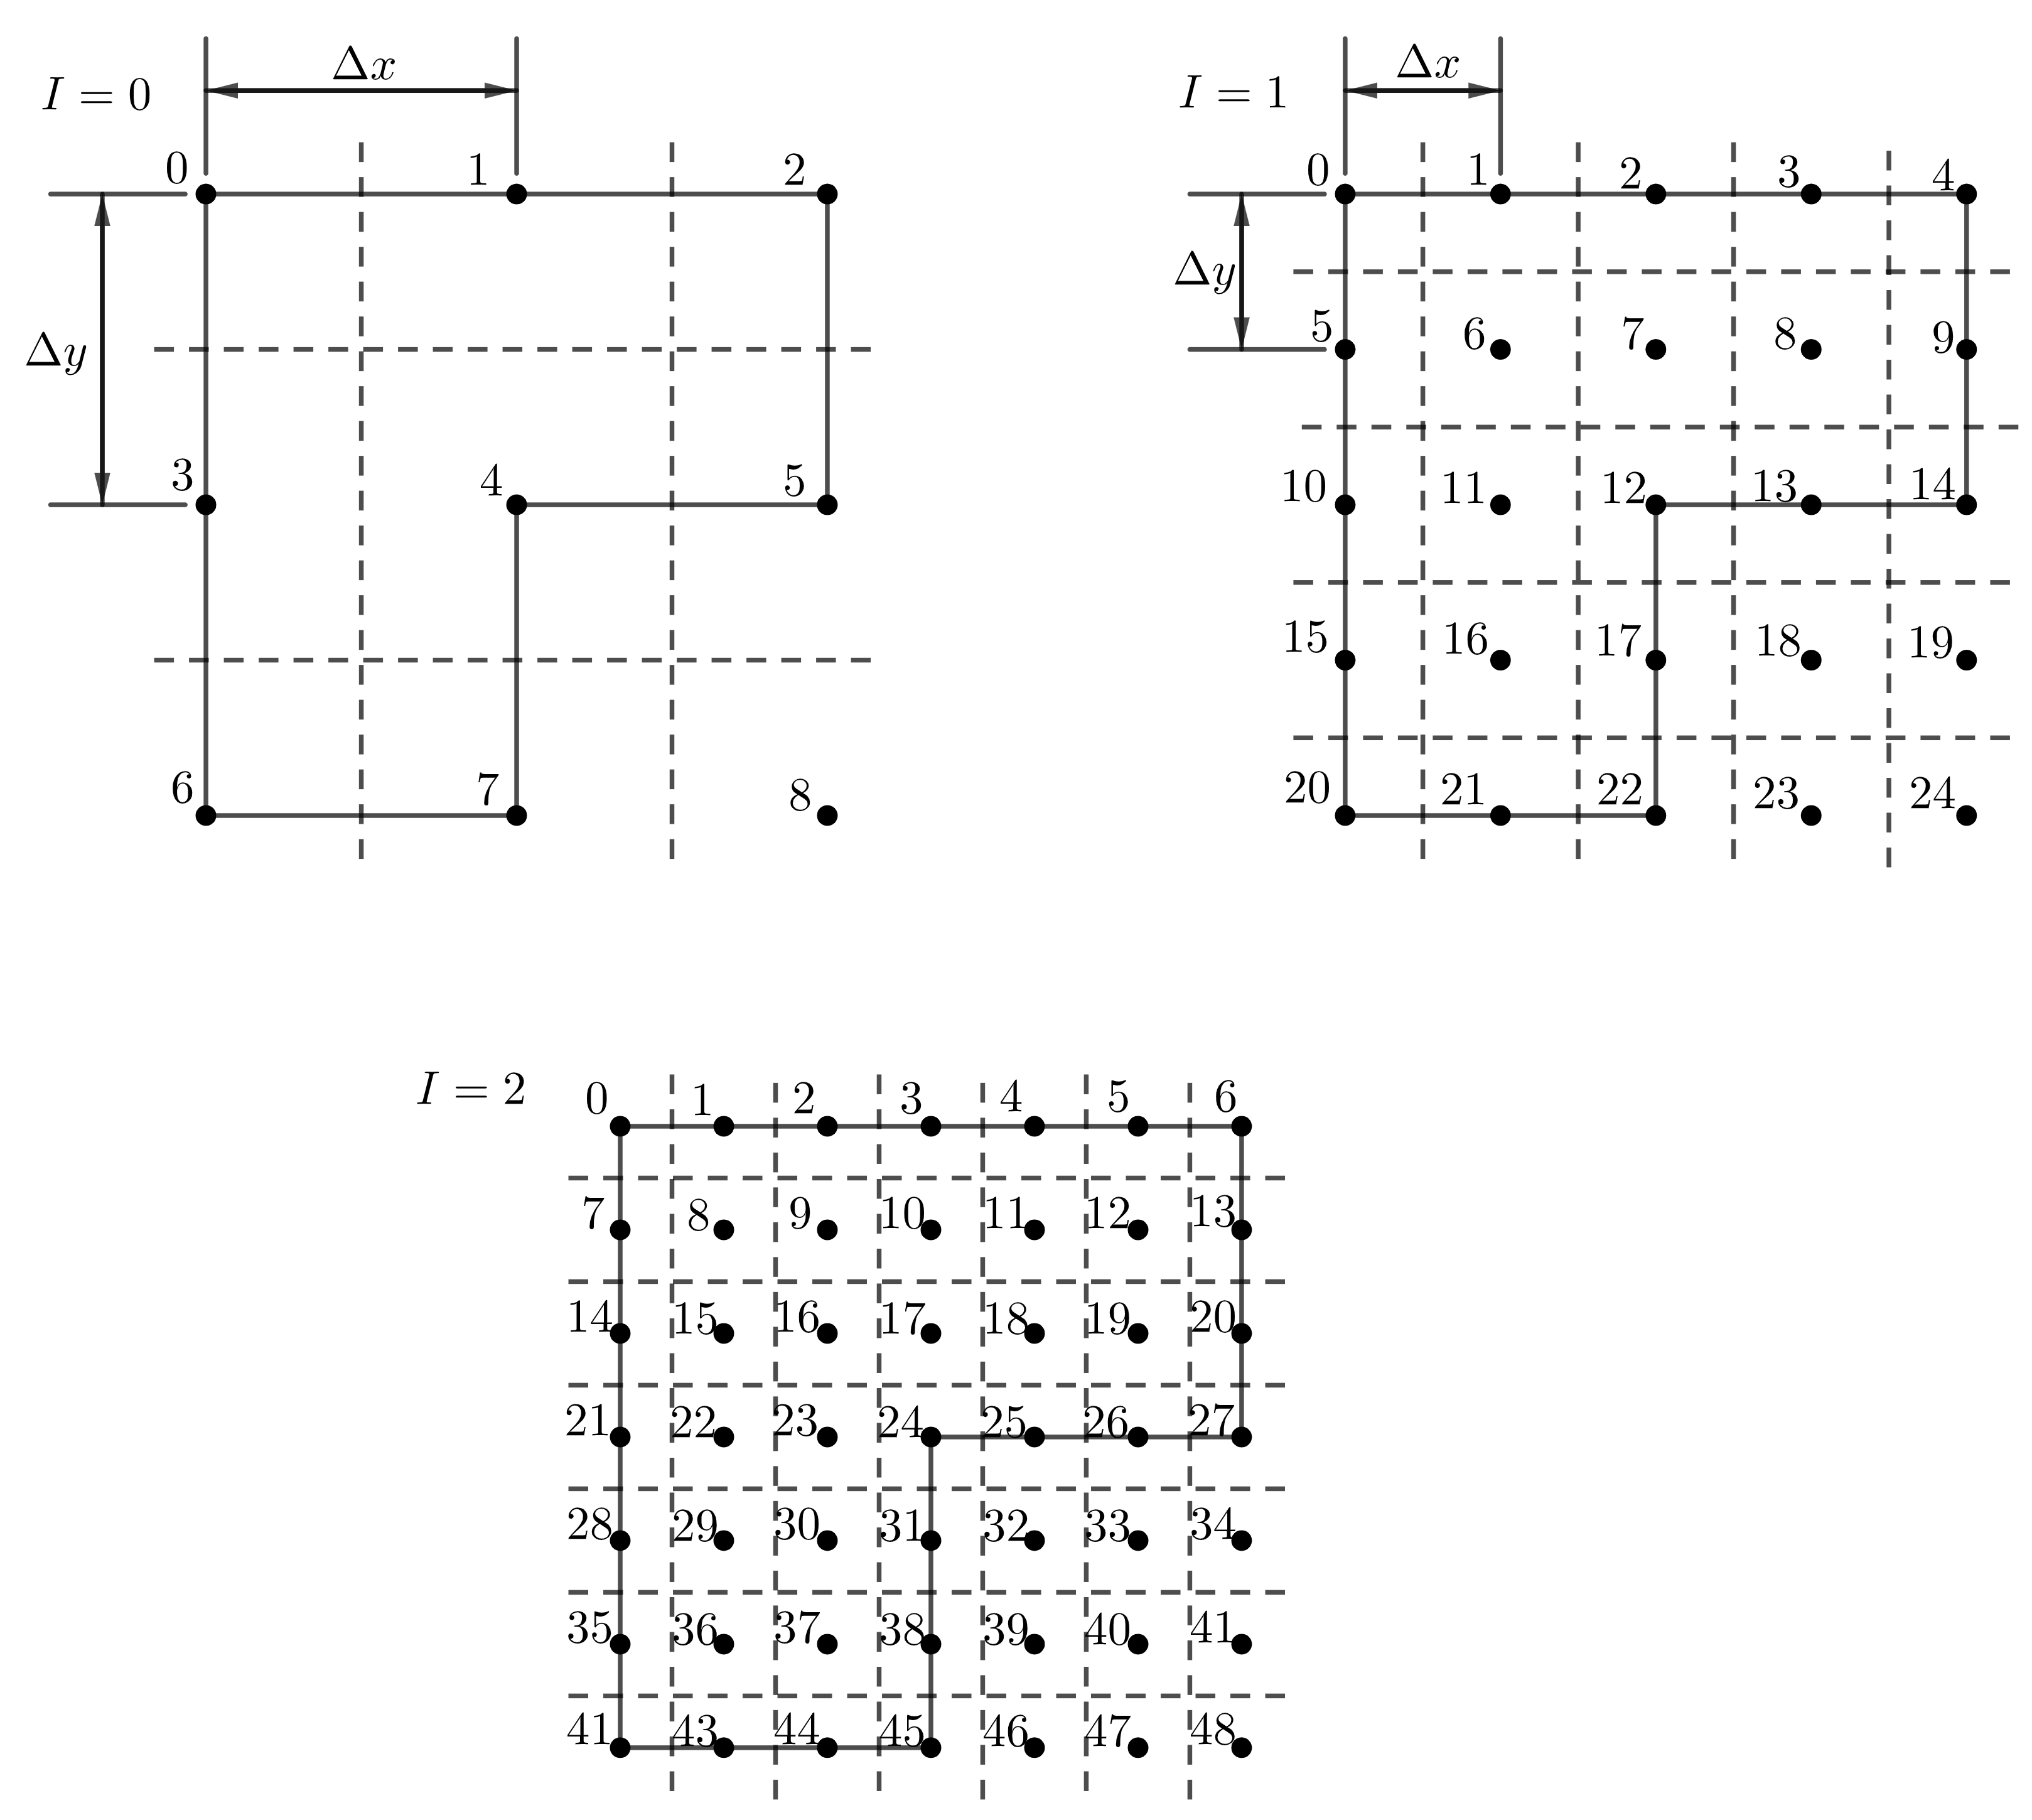

### Some remarks

**Remark 1**: Why is the first node 0? This is because in computer science, indexing starts at 0; we have to follow this convention.


**Remark 2**: Nodes that are completely surrounded by other nodes, i.e. all four edges are touching another node, are called interior nodes. Notice that sometimes we do not have any. <br> 
An exercise for you: Define a condition on $I$ such that we always have internal nodes. 


**Remark 3**: Observe how quickly the number of partitions grows. This is why if you make ```I``` too large, you will run out of memory. 

# 2. Setting up the problem on a computer

Now that we put in all our knowns and created a fully specified and partitioned domain for numerical analysis, we can move ahead to coding the problem so we can get our unknowns, the nodal temperatures. If you look back at all those different domains, finding the nodal temperatures can be thought of as finding the temperature at each dot. So, each dot represents an unknown temperature $T_i$, where $i$ is the node's index number.

## A system of equations

<br>

### Wait...an entire system of equations? How?
Remember that we said each node represents an unknown temperature. As we know, we need some kind of equation in order to solve for an unknown. We have $m$ nodes in $x$ and $n$ nodes in $y$. A quick way to find the total number of nodes is $m \cdot n$. Since each node is an unknown, we need $m \cdot n$ equations. So yes, we do have a system of equations. 


**Remark**: Depending on what your $I$ and $J$ are, the system can be very large!

### Ok...how do we solve a system then?
The coming nodal equations turn out to be linear, so matrix methods are a good way to solve a system of linear equations. Our goal is to set up and solve a problem of the form: $A\vec{x} = \vec{b}$. Following standard linear algebra terminology:

<br>
$A$ is the coefficient matrix. <br>
$\vec{x}$ is the vector of unknowns. <br>
$\vec{b}$ is the solution vector.

### So which is which?
$\vec{x}$ is the vector of unknowns, and the nodal temperatures are unknown. So, $\vec{x}$ is a vector that stores all the nodal temperatures. Simple enough, but how do we know what to place into $A$ and $\vec{b}$? 

<br>
To answer that, we'll need to start generating equations, but first we have to create an $A$ and a $\vec{b}$. Here we run into another problem: What size are they?

### Sizing the problem
We can answer this by thinking about $\vec{x}$. This is a column vector, with $m \cdot n$ entries. Let's just call this product $q$. This means $\vec{x}$ is a $q \times 1$, column vector.

<br>
We can use the definition of matrix multiplication and a property the $A$ matrix must have in order to find the dimensions of $A$, and then the product $A\vec{x}$ will tell us the dimensions of $\vec{b}$. 
<br>
<br>
Let's just start with an arbitrary size, $d \times c$, for $A$. In order for the matrix product $A\vec{x}$ to be defined, $c$ must be equal to $q$. Since we are looking to solve the problem $A\vec{x} = \vec{b}$, we require $A$ to be a square matrix. Thus, $A$ is a $q \times q$ matrix. Finally, the product $A\vec{x}$ has dimensions $q \times 1$, so $\vec{b}$ is a $q \times 1$ column vector.


**Remark**: $A$ being $q \times q$ also makes sense when you consider that it has to store all the coefficients for the equations. Since there are $q$ unknowns, there are $q$ equations, resulting in $A$ having $q$ rows. Having $q$ columns is then a requirement brought about by the nature of matrix multiplication.
### Initialize $A$ and $\vec{b}$
We want them to be empty, but we can't really just make matrices with nothing in them on a computer. We have to put *something* in there to start. Let's just put zeros in them to represent "nothing". We'll see later that this is actually a good choice.

In [7]:
q = n*m

A = np.zeros((q,q))
B = np.repeat(0,q)
pprint(A)
pprint(B)

#We printed A and B so you can get an idea of how the problem size grows with desired number of nodes.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0

### Wait, there was one index and now there are two??
Understanding how to interpret the indices of the entries of $A$ will be important in the next part, so we have to take a moment to make sense of the double index. 

<br>
Certainly, the single index that corresponds to the node number isn't so hard to understand. What $i$ is in $T_i$, we just go to the node that is numbered that.
<br>
<br>
For any entry of $A$, we have a double index $[k,l]$. To interpret an index pair, we'll first look at a grouping of indices. We know that each node has an equation attached to it, i.e. each node gets its own row in $A$. So, that would mean the $k$th row of $A$ is associated with the $k$th node. Thus, we can think of the first index as referring to the corresponding node index in our domain. 
<br>
<br>
$l$ ranges from $0$ to $q$. It turns out that $l$ also refers to the analogously indexed node that sits in our domain. 
<br>
<br>
When we take $k$ and $l$ as an index pair, what the $[k,l]$ means is "what is the relationship between node $k$ with node $l$?" 
<br>
<br>
Thinking about a row of $A$ again, as we go across it, $k$ is constant. All we are doing is going through all values of $l$ to fill up the row. This process is basically asking "For node $k$, what interaction does it have with node $l$?" 


**Conclusion**: Individual indices refer to the analogously indexed node in the domain, and the two together, as a pair, amount to asking "how they are related to each other?"

# 3. The nodal equations
We first have to identify the nodes that have a unique equation. 
<br>
<br>
Here's the domain from the beginning again, except we decided on an $I$:
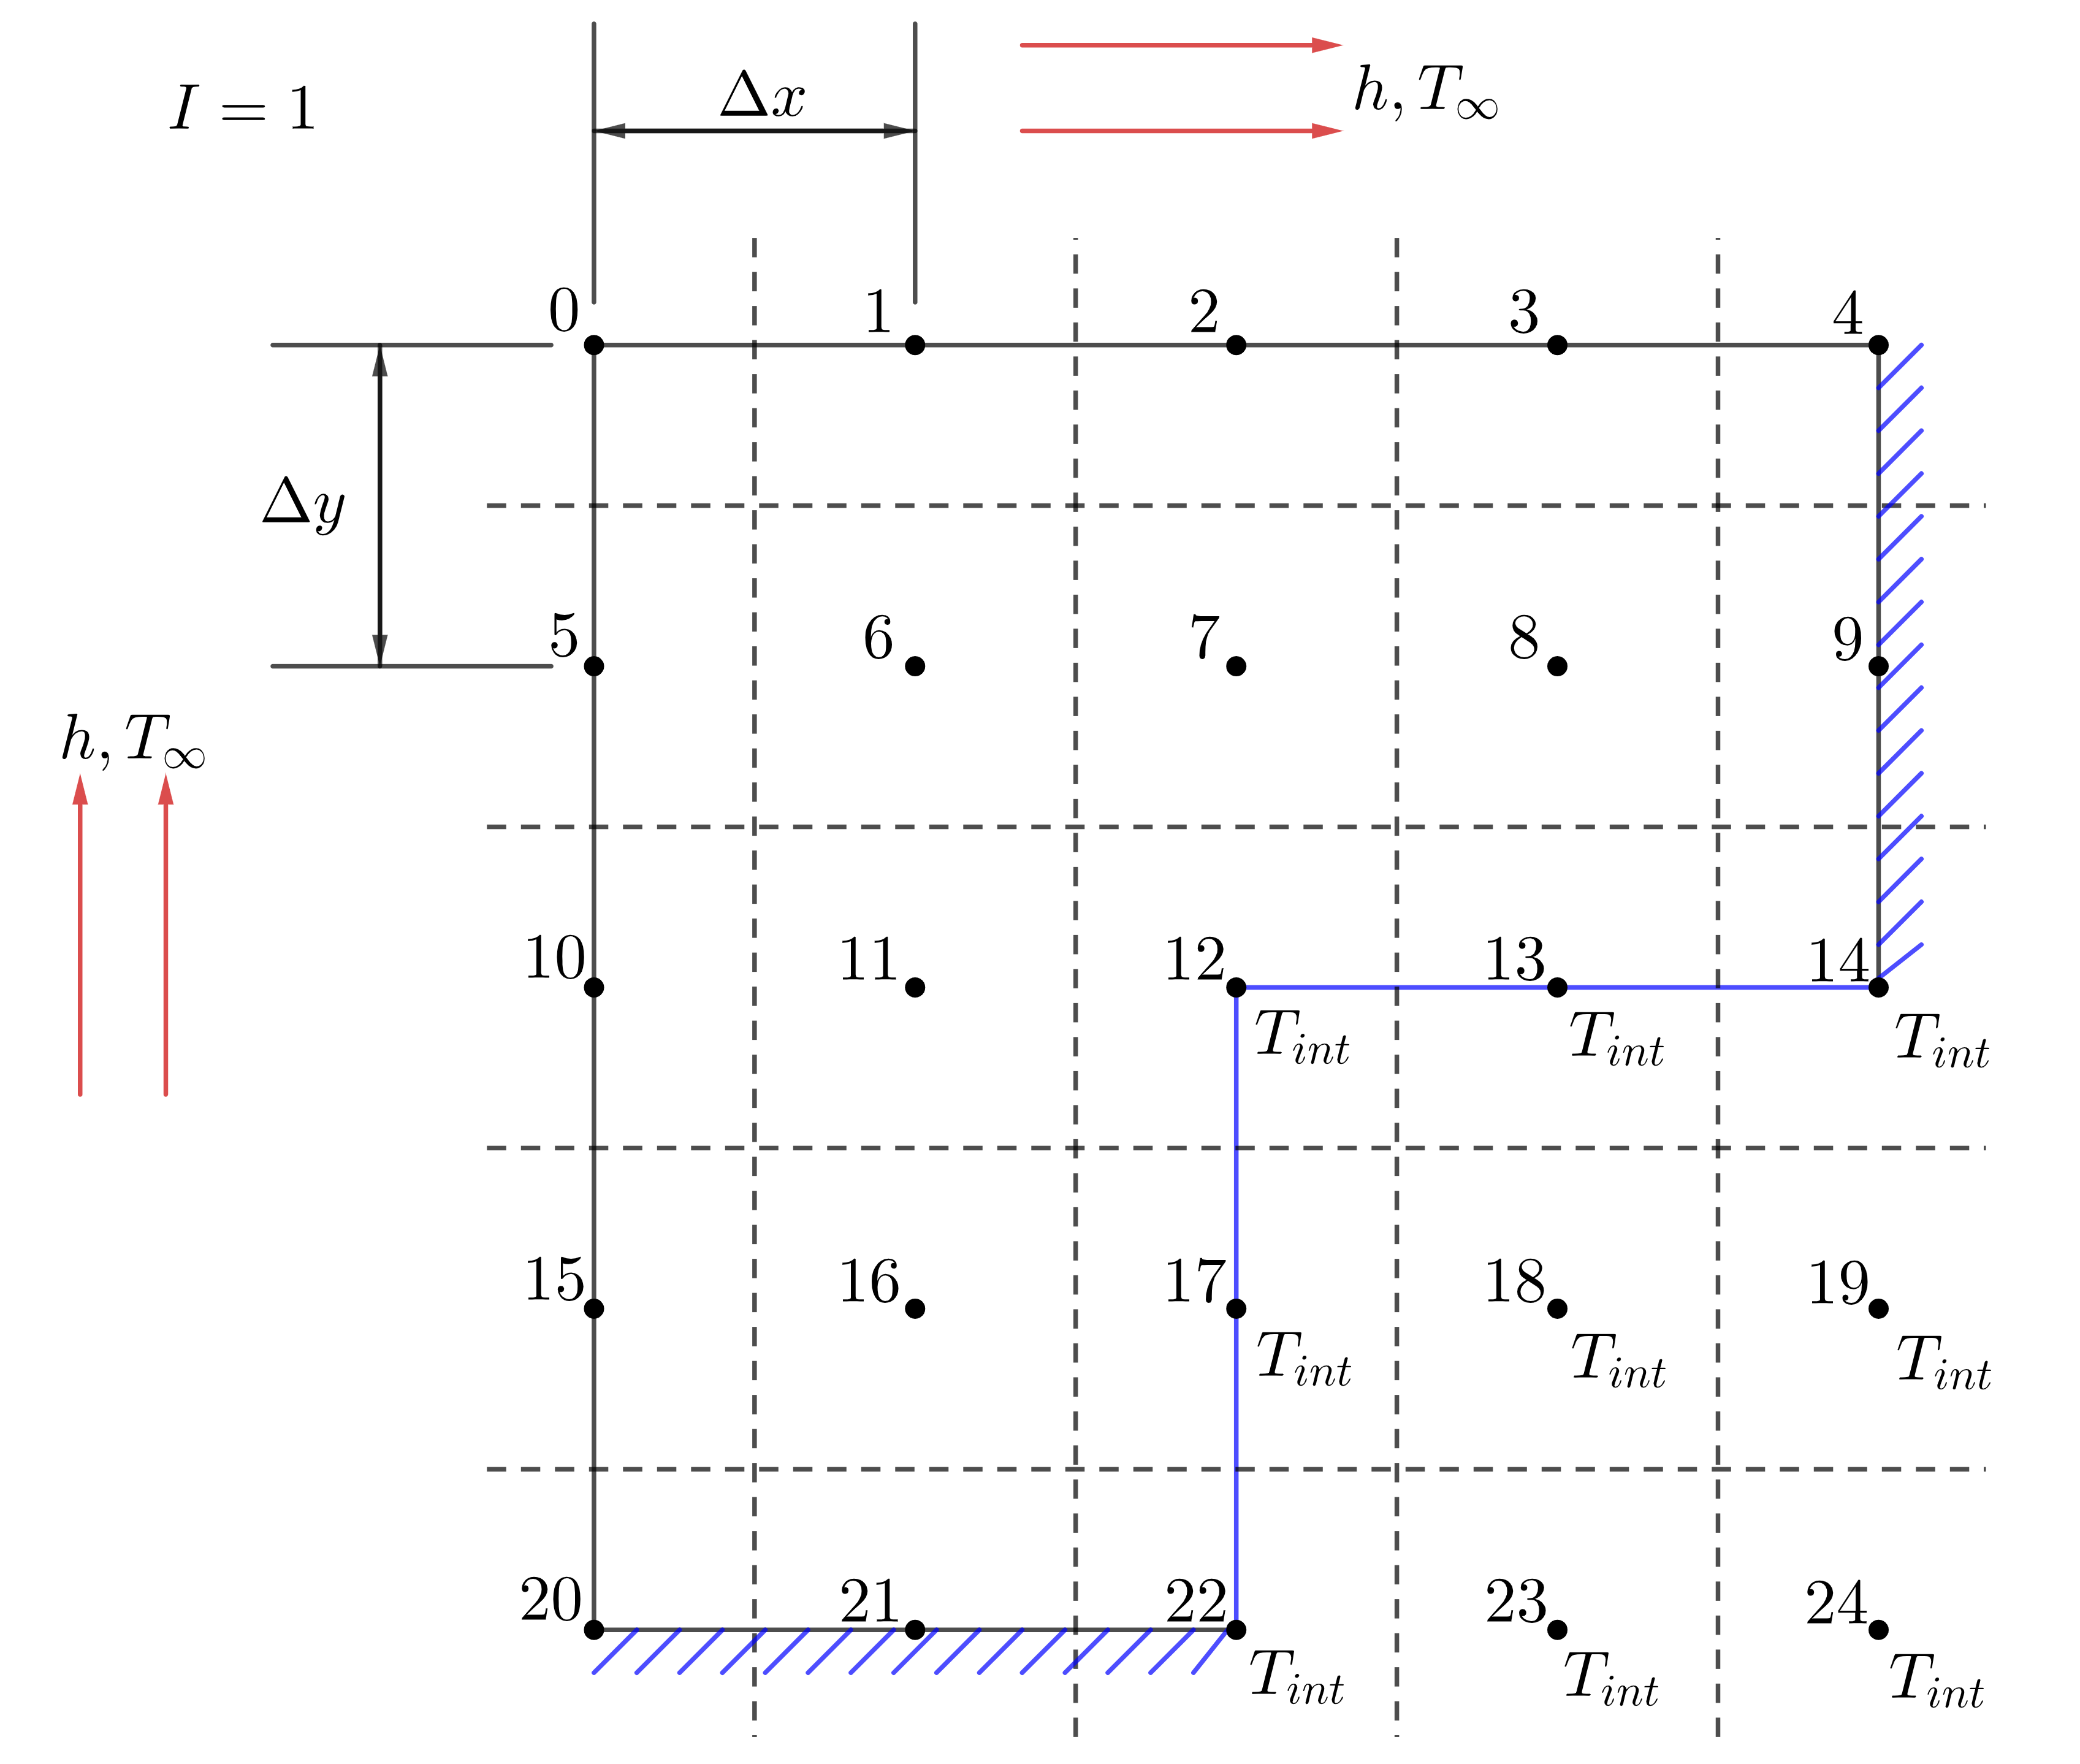

For any choice of allowable $I$, our situation always has the following unique nodes:

- Outer most nodes are exposed to convection
  - Node 0 has an area that is a quarter of a typical node
  - Node 4 has an area that is a quarter of a typical node, and one side is insulated
  - Nodes on the left side between the top left and bottom left corner have an area that is half of a typical node and three sides are subject to conduction
  - Bottom left corner has an area that is a quarter of a typical node, and one side is insulated
- Inner most nodes are at a given temperature

For large enough $I$ we also have:

- Interior nodes
- Insulated right side nodes that are not at a corner
- Insulated bottom side nodes that are not at a corner

<br>
We're going to work on all these nodes, even if we don't have all the cases sometimes. The code in this script is able to handle when they don't exist by simply outputting nothing when the choice of $I$ results in them not existing.


**Remark**: Aside from the fact that computers can do tedious calculations very fast, we see that the same situation can occur for sets of nodes, so computers help us out again by allowing us to utilize loops to take care of repeating situations.


**Remark**: Why did you fill in the inner corner? This choice is unique to using a computer to solve the problem as filling in the corner gives a consistent way to generally index the inner corner. Yes, we would save memory by not including them, but attempting to create a script that can accept arbitrary partitions is too difficult because there would no longer be a consistent way to index the inner corner without these nodes that "complete the square".

Here are all the required nodal equations. Try deriving at least some of them.

### Node zero
$-\left[\frac{\Delta x}{2 \Delta y} + \frac{\Delta y}{2 \Delta x} + \frac{h}{2k}(\Delta x + \Delta y)\right]T_0 + \left[\frac{\Delta y}{2 \Delta x}\right]T_1 + \left[\frac{\Delta x}{2 \Delta y}\right]T_5 = -\frac{h}{2k}T_{\infty}(\Delta x + \Delta y)$


### Node four
$-\left[\frac{\Delta x}{2 \Delta y} + \frac{\Delta y}{2 \Delta x} + \frac{h \Delta x}{2k}\right]T_4 + \left[\frac{\Delta y}{2 \Delta x}\right]T_3 + \left[\frac{\Delta x}{2 \Delta y}\right]T_9 = -\frac{h \Delta x}{2k}T_{\infty}$


### Top row
The equation for Node 1 is given as an example
<br>
<br>
$-\left[\frac{\Delta x}{\Delta y} + \frac{\Delta y}{\Delta x} + \frac{h \Delta x}{2k}\right]T_1 + \left[\frac{\Delta y}{2 \Delta x}\right](T_0+T_2) + \left[\frac{\Delta x}{\Delta y}\right]T_6 = -\frac{h\Delta x}{k}T_{\infty}$


### Nodes on the left side between the top left and bottom left corner
The equation for Node 5 is given as an example
<br>
<br>
$-\left[\frac{\Delta x}{\Delta y} + \frac{\Delta y}{\Delta x} + \frac{h \Delta x}{k}\right]T_5 + \left[\frac{\Delta x}{2 \Delta y}\right](T_0+T_{10}) + \left[\frac{\Delta x}{\Delta y}\right]T_6 = -\frac{h\Delta x}{k}T_{\infty}$


### Bottom left corner
$-\left[\frac{\Delta x}{2 \Delta y} + \frac{\Delta y}{2 \Delta x} + \frac{h \Delta y}{2k}\right]T_{20} + \left[\frac{\Delta x}{2 \Delta y}\right]T_{15} + \left[\frac{\Delta y}{2 \Delta x}\right]T_{21} = -\frac{h \Delta y}{2k}T_{\infty}$


### Insulated bottom side
The equation for Node 21 is given as an example
<br>
<br>
$-\left[\frac{\Delta x}{\Delta y} + \frac{\Delta y}{\Delta x}\right]T_{21} + \left[\frac{\Delta y}{2 \Delta x}\right](T_{20}+T_{22}) + \left[\frac{\Delta x}{\Delta y}\right]T_{16} = 0$


### Insulated right side
We only happen to have one for the choice $I=1$. 
<br>
<br>
$-\left[\frac{\Delta x}{\Delta y} + \frac{\Delta y}{\Delta x}\right]T_9 + \left[\frac{\Delta x}{2 \Delta y}\right](T_4+T_{14}) + \left[\frac{\Delta y}{\Delta x}\right]T_8 = 0$


### Interior nodes
The equation for Node 6 is given as an example
<br>
<br>
$-2\left[\frac{\Delta x}{\Delta y} + \frac{\Delta y}{\Delta x}\right]T_6 + \left[\frac{\Delta y}{\Delta x}\right](T_5+T_7) + \left[\frac{\Delta x}{\Delta y}\right](T_1+T_{11}) = 0$


### Inside nodes at a known temperature
Take for an example Node 22
<br>
<br>
Known: $T_{22}$ = T_int


### Questions for you
1. We left $\Delta x$ and $\Delta y$ in there so you could practice deriving the nodal equations in a more general way. Given that $\Delta x = \Delta y$, how do the nodal equations simplify?
<br>
<br>
2. After simplification, is there any symmetry you can spot between the equations, i.e. same equation except location numbers are different?

## How do we use the equations to fill $A$ and $\vec{b}$?

### The entries of $A$
Now we have equations to describe every node. We see that there are coefficients and that only some nodes appear in the equations. Let's look at the equation for node 0. 
<br>
<br>
$-\left[\frac{\Delta x}{2 \Delta y} + \frac{\Delta y}{2 \Delta x} + \frac{h}{2k}(\Delta x + \Delta y)\right]T_0 + \left[\frac{\Delta y}{2 \Delta x}\right]T_1 + \left[\frac{\Delta x}{2 \Delta y}\right]T_5 = -\frac{h}{2k}T_{\infty}(\Delta x + \Delta y)$
<br>
<br>
Because this equation is associated with the zero node, this equation tells us that these coefficients that belong in the zeroth row of $A$.
<br>
<br>
Thinking back to how we discussed indexing the entries of $A$, we have $[k,l]$. Working with node zero fixes $k$ as zero. Now we step through all values of $l$ and ask ourselves "how does node $l$ interact with node zero?"
<br>
<br>
Immediately we see the term: $-\left[\frac{\Delta x}{2 \Delta y} + \frac{\Delta y}{2 \Delta x} + \frac{h}{2k}(\Delta x + \Delta y)\right]T_0$. 

This is telling us that the interaction of node zero with itself is described by the coefficient $-\left[\frac{\Delta x}{2 \Delta y} + \frac{\Delta y}{2 \Delta x} + \frac{h}{2k}(\Delta x + \Delta y)\right]$. This means $a_{00} = -\left[\frac{\Delta x}{2 \Delta y} + \frac{\Delta y}{2 \Delta x} + \frac{h}{2k}(\Delta x + \Delta y)\right]$.
<br>
<br>
Next we have $\left[\frac{\Delta y}{2 \Delta x}\right]T_1$.

This tells us that the interaction of node zero with node 1 is described by $\frac{\Delta y}{2 \Delta x}$. Thus, $a_{01} = \frac{\Delta y}{2 \Delta x}$.


**Fill in the question mark**: $\frac{\Delta x}{2 \Delta y}$ is entry $a_{0?}$
<br>
<br>
This takes care of the three terms on the left hand side, but what about all the terms that are not there? We have to fill up the row somehow, so what about the coefficient for the interaction with $T_2$? $T_3$? $T_4$?...$T_{6-24}$? Well, if they are not there, then we can view it as $0 \cdot T_i$. This is telling us that node zero has no interaction with node $i$. Certainly that's true, so $a_{0i} = 0$. 
<br>
<br>
Now we see why it turns out to be a good idea to initialize $A$ with nothing but zeros to start!

### The entries of $\vec{b}$

Recall that $\vec{b}$ is the solution vector. The right hand side of the nodal equation is the solution, thus whatever is on the right hand side of the equation is what we should put into $\vec{b}$.
<br>
<br>
Some examples:
<br>
<br>
Node 0 has the right hand side: $-\frac{h}{2k}T_{\infty}(\Delta x + \Delta y)$. This means that $b_0 = -\frac{h}{2k}T_{\infty}(\Delta x + \Delta y)$.

Node 6 has a right hand side of zero, so $b_6 = 0$.

**Remark**: Many of the nodal equations have a right hand side of zero
<br>
<br>
Again, we now see why it is a good choice to initialize $\vec{b}$ as a vector of all zeros!

### Exercises for you
Write out the entire row of $A$ that is associated with node 2. What is $b_2$? <br>
Do the same exercise for nodes 8 and 10.  

<br>
Write out the entire row for node 22 and multiply it with $\vec{x}$ as a demonstration of the correctness of its nodal equation given earlier.

Below is code that generalizes the indices so that you could input any acceptable $I$ and get a solution. <br>

The interested user can attempt to do the generalization, using the specific case of $I=1$ and the various partitioned domains shown earlier as guides, though hard coding indices is likely something one may do if a problem with a fixed, predetermined partition scheme is of interest instead of coding to allow arbitrary partitioning.

In [8]:
#Top left corner [0,0]
A[0,0] = -((dx/(2*dy))+(dy/(2*dx))+((h/(2*k))*(dx+dy)))
A[0,1] = dy/(2*dx)
A[0,n] = dx/(2*dy)
B[0] = -T_inf*(h/(2*k))*(dx+dy)

#Top line of nodes before in between top left and right corner
for i in range(1,m-1):
    A[i,i-1] = dy/(2*dx)
    A[i,i] = -((dx/dy)+(dy/dx)+((h*dx)/k))
    A[i,i+1] = dy/(2*dx)
    A[i,i+n] = dx/dy 
    B[i] = -T_inf*((h*dx)/k)
    
#Top right corner [0,m]
A[m-1,m-2] = dy/(2*dx)
A[m-1,m-1] = -((dx/(2*dy))+(dy/(2*dx))+(((h*dx)/(2*k))))
A[m-1,m-1+n] = dx/(2*dy)
B[m-1] = -T_inf*((h*dx)/(2*k))

#Insulated right side that are not corner nodes
e = int(m+n-1)
E = ((m*n)-((I+2)*m))
for i in range(e,E,m):
    A[i,i-n] = dx/(2*dy)
    A[i,i] = -((dx/dy)+(dy/dx))
    A[i,i+n] = dx/(2*dy)
    A[i,i-1] = dy/dx

#Left side nodes that are not corner nodes
N = int((n*n)-n-1)
for i in range(n,N,n):
    A[i,i-n] = dx/(2*dy)
    A[i,i+n] = dx/(2*dy) 
    A[i,i] = -((dx/dy)+(dy/dx)+((h*dy)/k))
    A[i,i+1] = dy/dx
    B[i] = -T_inf*((h*dy)/k)
    
#Bottom left corner 
R = int((n*m)-m)
A[R,R-n] = dx/(2*dy)
A[R,R] = -((dx/(2*dy))+(dy/(2*dx))+(((h*dy)/(2*k))))
A[R,R+1] = dy/(2*dx) 
B[R] = -T_inf*((h*dy)/(2*k))

#Insulated bottom side that are not corner nodes
for i in range(R+1,R+I+1):
    A[i,i-1] = dy/(2*dx)
    A[i,i] = -((dy/dx)+(dx/dy))
    A[i,i+1] = dy/(2*dx)
    A[i,i-n] = dx/dy

#Internal nodes 
#vertical part of the corner
u = int((2*m)-1)
U = int(I*m)
for i in range(m+I+1,u):
    j = range(i,i+U,n)
    r = len(j)
    for l in range(0,r):
        v = j[l]
        A[v,v-n] = dx/dy
        A[v,v+n] = dx/dy
        A[v,v-1] = dy/dx
        A[v,v+1] = dy/dx
        A[v,v] = -2*((dx/dy)+(dy/dx))

#horizonal part of the corner 
W = int((n*m)-m+1-m)
for i in range(m+1,m+I+1):
    j = range(i,W+I,n)
    r = len(j)
    for l in range(0,r):
        v = j[l]
        A[v,v-n] = dx/dy
        A[v,v+n] = dx/dy
        A[v,v-1] = dy/dx
        A[v,v+1] = dy/dx
        A[v,v] = -2*((dx/dy)+(dy/dx))
    
#Inner most nodes that are at a given temperature (the part that "completes the square")
s = int((n*m)-1)
S = int(s/2)
for i in range(S, s, n):
    j = range(i, i+m-I-1)
    r = len(j)
    for l in range(0,r):
        v = j[l]
        A[v,v] = 1
        B[v] = T_int

In [9]:
pprint(A)
pprint(B)

#We just print A and b because it's always good to look at what you've created in order to spot any mistakes

array([[-1.45454545,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5       , -2.45454545,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.5       , -2.45454545, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])
array([-136, -136, -136, -136, -136, -136, -136, -136, -136, -136, -136,
       -136, -136, -136, -136, -136, -136, -136, -136, -136, -136, -136,
        -68, -136,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, -136,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    

# 5. Solution algorithm

This is actually the easiest step of the entire process. Since we have a square matrix and a solution vector, we just use Python's built in matrix equation solver to do the work for us. 

In [10]:
T = np.linalg.solve(A,B) #this gives us x, the column vector of all the nodal temperatures

T_map = T.reshape(n,m) #we then reshape the column vector into a matrix of dimension n x m
                       #reshaping in this way allows us to map the entries to the domain
                       #the first entry in the top left is T_0. the next entry to the right is T_1. the entry underneath T_0 is T_5 and so forth. 
                       #Thus, this matrix is the temperature map

T_map_rounded = np.around(T_map, decimals=2) #the solution has values with more significant figures than you probably need, so just set decimals to how ever many significant figures you want

#We'll print T just in case you find that easier to work with when you are looking for a specific nodal temperature
print("T:")
pprint(T)

print("T_map_rounded:")
pprint(T_map_rounded)

T:
array([298.71080544, 298.48844428, 298.26616579, 298.04429312,
       297.82346348, 297.60469377, 297.38942623, 297.17953567,
       296.97727614, 296.78514782, 296.60567974, 296.4411525 ,
       296.29332048, 296.16321249, 296.05107035, 295.95642971,
       295.87829928, 295.8153787 , 295.76626632, 295.72962971,
       295.70433047, 295.68950738, 295.68462656, 298.48844428,
       298.16496853, 297.84149278, 297.5184503 , 297.19673509,
       296.87780348, 296.56374967, 296.25732729, 295.9618815 ,
       295.68115762, 295.41897284, 295.1787833 , 294.96324051,
       294.77387161, 294.61098794, 294.47382448, 294.3608304 ,
       294.27001036, 294.1992404 , 294.14651998, 294.11015169,
       294.08885779, 294.08184871, 298.26616579, 297.84149278,
       297.41638649, 296.99128021, 296.5672231 , 296.14603541,
       295.73044168, 295.3241423 , 294.93176494, 294.55862832,
       294.21027069, 293.89176735, 293.60698664, 293.3580455 ,
       293.14518532, 292.96704986, 292.82118749, 292

# 6. Visualization

Here is code that generates a heat map of our solution. <br>
Recall that the inside of the corner is filled in with nodes at ```T_int```.

### Question for you
How do you map physical lengths to the node locations of the heat map below?

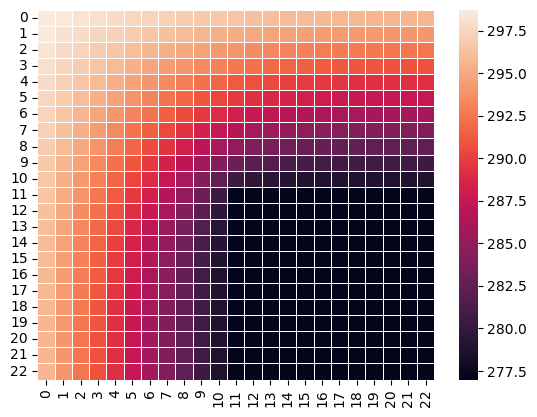

In [11]:
ax = sns.heatmap(T_map_rounded, linewidth=0.5)
plt.show()

# 7. Things to think about and try out

This is the end of the example. Hopefully the entire analysis and solution process came through to you, such that you are now primed to pose, code, and solve problems of your very own. If you want a deeper dive into solution methods such as this, serach "finite difference methods". 
<br> 
<br>
But before you go, here are some things you can think about or try out:
<br>
1. What will the result be if ```h=0```? Take a guess before trying it out in the script. Once you see the result from the script, how do you explain it?
<br>
2. Explore the role of the convection heat transfer coefficient by varying that while ```k``` is constant.
<br>
3. Explore the role of thermal conductivity by varying that while ```h``` is constant.
<br>
4. Derive the relevant nodal equations for different boundary conditions.
<br>
5. We used a constant $\Delta x$ and $\Delta y$. As we said earlier, this was mainly to create a simple yet illustrative example of the numerical solution method. Part of the power of numerical methods is that $\Delta x$ and $\Delta y$ can vary. This complicates the problem with more and more unique equations of course, but in return you have the freedom to vary how you create rectangles as your situation requires. What are situations you can think of where you would want to vary $\Delta x$ or $\Delta y$?